---

# **I. Import Libraries**

Let's start with importing essential libraries.

In [3]:
import numpy as np              # scientific computing
import pandas as pd             # high-performance data structures
import matplotlib.pyplot as plt # data visualization
import seaborn as sb            # high-level data visualization
import os

---

# **V. Prepare the Data for Machine Learning Algorithms**

At this stage, we will separate the predictors and labels as well as split the dataset into training set and test set. In addition, we will also perform feature scaling technique in order to help Machine Learning models learn better from the dataset.

In [4]:
cardio = pd.read_csv('cardio_train.csv', sep = ';')
# Separate the dataset
cardio_label = pd.DataFrame(cardio['cardio']) # label
cardio = cardio.drop('cardio', axis=1)        # predictors

NameError: name 'cardio' is not defined

### V.1. Feature Scaling

Very often, Machine Learning don't perform well when the input numerical attributes have very different scales. In this **Cardiovascular Disease dataset**, the range of each numerical attribute is as follow.

Let's check the statistical summary of numerical attributes again.

In [ ]:
# Summary of numerical attributes' statistics
cardio.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,70000.0,52.803257,6.762462,29.0,48.0,53.0,58.0,64.0
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0


Although the scales of the input numerical attributes are not too different, we will still rescale them because it is a good practice to do so.

We will be using [Standardization Scaling](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf).

In [ ]:
# Import scaler
from sklearn.preprocessing import StandardScaler

# Define scaler object
scaler = StandardScaler()

# Scale numerical attributes
cardio[num_attribs] = scaler.fit_transform(cardio[num_attribs])

### V.2. Split the Dataset

Now, let's split the dataset into two parts:


1.   Training set for training models
2.   Test set for evaluating models


with the ratio $\frac{training\space set}{test\space set} = \frac{8}{2}$ and a random state to get the same datasets everytime running.

In [ ]:
# Import splitter
from sklearn.model_selection import train_test_split

# Split the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(cardio, cardio_label, test_size=0.2, random_state=42)

---

# **VI. Select and Train a Model**

Finally we come to this stage, where we will select and train a Machine Learning model.

We're going to plot the [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62) and the [Receiver Operating Characteristic (ROC) curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) multiple times, therefore, creating functions for those tasks is a good practice as it will help reduce repetitive lines of code.

In [ ]:
class ModelEvaluation():
  def __init__(self, y):
    # Ground truth of the target class
    self.y = y

  def plot_confusion_matrix(self, y_pred):
    # Plot actual class against predicted class
    sb.heatmap(confusion_matrix(self.y, y_pred), annot=True, fmt='.0f', annot_kws={'size':18})

    # Print scores
    print("Accuracy:\t", accuracy_score(self.y, y_pred))   # accuracy
    print("Precision:\t", precision_score(self.y, y_pred)) # precision
    print("Recall:\t\t", recall_score(self.y, y_pred))     # recall
    print("F1 score:\t", f1_score(self.y, y_pred))         # f1 score
    print("ROC AUC:\t", roc_auc_score(self.y, y_pred))     # area under roc curve

  def plot_roc_curve(self, y_probas):
    # Keep probabilities for the successful outcome
    y_scores = y_probas[:, 1]

    # Calculate roc curves
    fpr, tpr, thresholds = roc_curve(self.y, y_scores)

    # Calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1 - fpr))

    # Locate the index of the largest g-mean
    index = argmax(gmeans)

    # Best threshold
    self.threshold = thresholds[index]

    # Plot the roc curve for the model
    plt.plot([0,1], [0,1], 'k--', label='No Skill')                             # purely random classifier
    plt.plot(fpr, tpr, label='Logistic')                                        # trained classifier
    plt.scatter(fpr[index], tpr[index], marker='o', color='red', label='Best')  # best classifier

    # Label axes
    plt.xlabel("False Positive Rate (Fall-Out)")  # x-axis label
    plt.ylabel("True Positive Rate (Recall)")     # y-axis label
    plt.legend(loc='lower right')                 # legend
    plt.grid(True)                                # plot grid

    # Show the plot
    plt.show()

    # Print the best threshold and g-mean
    print("Best Threshold =", self.threshold) # best threshold
    print("G-Mean =", gmeans[index])          # g-mean

  def best_threshold(self):
    # Return the best threshold
    return self.threshold

Let's start with the [Decision Tree Classifier](https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575) model.

The intuition behind Decision Trees is that we use the dataset features to create yes/no questions and continually split the dataset until we isolate all data points belonging to each class.

With the Decision Tree Classifier, the right question to ask is: "*At a particular node, what feature will allow me to split the observations at hand in a way that the resulting groups are as different from each other as possible (and the members of each resulting subgroup are as similar to each other as possible)?*"

### VI.1. Train and Evaluate on Training Set

We will be using GridSearchCV to find the best combination of hyper-parameters for an estimator. The hyper-parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a hyper-parameter grid.

In [ ]:
# Import classification model and hyper-parameter optimizer
from sklearn.model_selection import GridSearchCV  # optimizer
from sklearn.tree import DecisionTreeClassifier   # model

# A dictionary contains hyper-parameters combinations that we want to examine
dectree_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(5, 10),
    'random_state': [42]
}

# Setup grid search
search_dectree = GridSearchCV(DecisionTreeClassifier(),
                              param_grid=dectree_param_grid,
                              scoring='roc_auc',
                              cv=10,
                              verbose=3)

# Fit the training set on the model with combinations of hyper-parameters
search_dectree.fit(X_train, y_train)

# The best hyper-parameters combination
search_dectree.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.780, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.779, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, random_state=42, score=0.773, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.772, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.772, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.775, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.776, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.764, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.778, total=   0.1s
[CV] criterion=gini, 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.5s finished


{'criterion': 'entropy', 'max_depth': 7, 'random_state': 42}

Let's create a model object using the best combination of hyper-parameters found and fit it on the training set.

In [ ]:
# Create model object with the best found hyper-parameters combination
dectree = search_dectree.best_estimator_

# Fit the training set on the model
dectree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

After predicting on the training set, we will plot the confusion matrix and print out some scores to evaluate the model.

Accuracy:	 0.7291428571428571
Precision:	 0.7502835464820681
Recall:		 0.6859512997461293
F1 score:	 0.7166766288105199
ROC AUC:	 0.7290920127311249


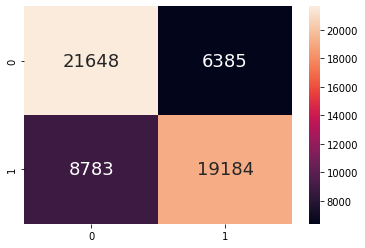

In [ ]:
# Import classification metrics
from sklearn.metrics import confusion_matrix                                                        # confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # metrics

# Create model evaluation object
evaluation = ModelEvaluation(y_train)

# Predict target class based on training set
y_train_pred = dectree.predict(X_train)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_train_pred)

It seems like the way the dataset was preprocessed causes this model to be underfitted on the training set.

One way to evaluate the Decision Tree model would be to use the `train_test_split()` function to split the training set into a smaller training set and a validation set, then train the model against the smaller training set and evaluate them against the validation set.

A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into $10$ distinct subsets
called folds, then it trains and evaluates the Decision Tree model $10$ times, picking a different fold for evaluation every time and training on the other $9$ folds. After that, it will return the average of predictions made on each test fold.

Accuracy:	 0.72575
Precision:	 0.7459908697178977
Recall:		 0.6836271319769729
F1 score:	 0.7134487648331966
ROC AUC:	 0.7257004136323348


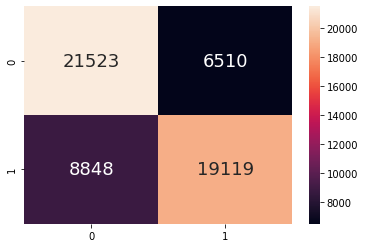

In [ ]:
# Import cross-validation predictor
from sklearn.model_selection import cross_val_predict # model validation

# Use cross-validation to predict target class based on training set
y_train_pred = cross_val_predict(dectree, X_train, y_train.values.flatten(), cv=10)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_train_pred)

Check the importance of each feature.

In [ ]:
# The impact of each feature on the model
importances = list(zip(dectree.feature_importances_, X_train.columns))  # list of important features
importances.sort(reverse=True)                                          # sort the importances

# Print feature ranking
i = 1
for f in importances:                         # iterate over the list of important features
  print("{}. {} ({})".format(i, f[1], f[0]))  # print the ranking
  i += 1

1. bp (0.6841486379878592)
2. age (0.1639902537110131)
3. cholesterol (0.09226845074873881)
4. weight (0.02946713082941161)
5. height (0.012228396041321036)
6. gluc (0.011037865290498987)
7. active (0.004161865394963023)
8. smoke (0.0014818211591808214)
9. alco (0.0006886183926526189)
10. gender (0.0005269604443607237)


The blood pressure is the most dominant feature in this model, followed by the age. As expected, smoking, alcohol intake and gender aren't contribute much to the prediction of the model.

Great adventage of the Decision Tree Classifier is that we can actually see the tree and observe how the algorithm classifies training examples at each node.

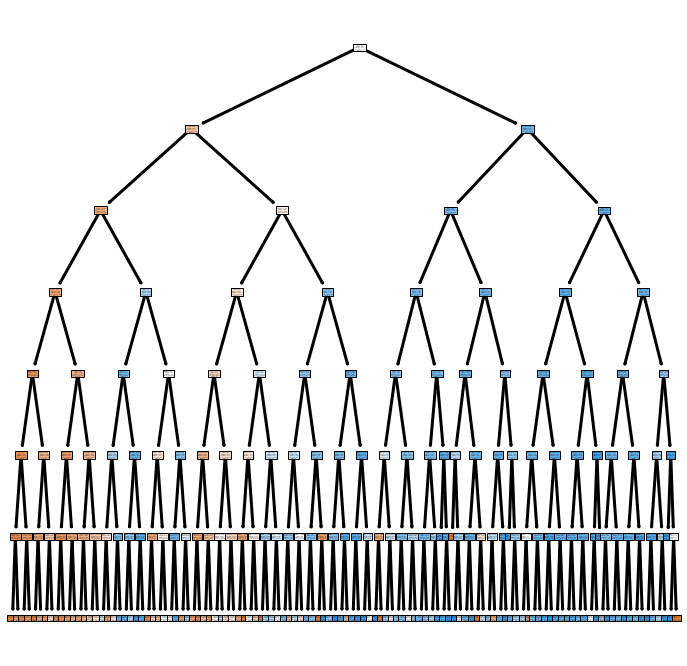

In [ ]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

fig, axes = plt.subplots(figsize=(12,12))
out = plot_tree(dectree,
                feature_names=X_train.columns,
                class_names=[str(x) for x in dectree.classes_],
                filled=True)

for o in out:
  arrow = o.arrow_patch
  if arrow is not None:
    arrow.set_edgecolor('black')
    arrow.set_linewidth(3)
        
plt.show()

Now, we will take a step back and change the way we preprocessed the dataset.

---

# **VII. Fine-tune the Model**

### VII.1. Reprocess the Data

This time, we will filter out the outliers from the original data set. They are training examples with:


*   `ap_hi` and `ap_lo` values those below $40$ or above $200mmHg$
*   `ap_lo` greater than `ap_hi`
*   `bmi` values those below $10$ and above $80kg/m^2$


The height and weight features seems to be in rational ranges but when we combine the two features to calculate the BMI, some unreasonable values start to appear. We will filter out those odd values.

In [ ]:
# Create a copy of the dataset
cardio2 = cardio.copy()

# Numerical and categorical attributes
num_attribs = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_attribs = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Covert the data type of categorical attributes into "category"
for cat_attrib in cat_attribs:
  cardio2[cat_attrib] = cardio2[cat_attrib].astype('category')

# Remove the id column
cardio2 = cardio2.drop(columns='id')

# Convert the age into years
cardio2['age'] = cardio2['age'] // 365.25

# Convert gender to binary categorical attribute
cardio2['gender'] = (cardio2['gender'].astype('int') - 1).astype('category')

# Extract Systolic (ap_hi) and Diastolic (ap_lo) blood pressure features
ap_hi = cardio2['ap_hi']
ap_lo = cardio2['ap_lo']

# Drop data points those have ap_hi and ap_lo lower than 40 and higher than 200
cardio2 = cardio2.drop(cardio2.loc[(ap_hi < 40) | (ap_hi > 200) | (ap_lo < 40) | (ap_lo > 200)].index)

# Some data points have ap_lo > ap_hi, we will filter these as well
cardio2 = cardio2.drop(cardio2.loc[ap_lo > ap_hi].index)

# Caculate BMI for every patients
cardio2['bmi'] = cardio2['weight'] / (cardio2['height'] / 100) ** 2

# Extract BMI (bmi) feature
bmi = cardio2['bmi']

# Drop data points those have bmi lower than 10 and higher than 80
cardio2 = cardio2.drop(cardio2.loc[(bmi < 10) | (bmi > 80)].index)

# Drop BMI (bmi) feature
cardio2 = cardio2.drop(columns=['bmi'])


Let's check the infomation of the processed dataset.

In [ ]:
# Basic information about the dataset
cardio2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68586 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          68586 non-null  int64   
 1   gender       68586 non-null  category
 2   height       68586 non-null  int64   
 3   weight       68586 non-null  float64 
 4   ap_hi        68586 non-null  int64   
 5   ap_lo        68586 non-null  int64   
 6   cholesterol  68586 non-null  category
 7   gluc         68586 non-null  category
 8   smoke        68586 non-null  category
 9   alco         68586 non-null  category
 10  active       68586 non-null  category
 11  cardio       68586 non-null  category
dtypes: category(7), float64(1), int64(4)
memory usage: 3.6 MB


The dataset is dropped by around $2$%.

### VII.2. Exploratory Analysis

In [ ]:
# Bivariate analysis with respect to target class
fig , ax = plt.subplots(nrows = len(num_attribs), figsize = (8,15))
count = 0
for number in num_attribs:
	sb.kdeplot(data = cardio2, x =number, hue = "cardio", ax = ax[count])
	count +=1

NameError: name 'num_attribs' is not defined

Use `catplot()` to observe the correlations between categorical attributes and the target variable `cardio`.

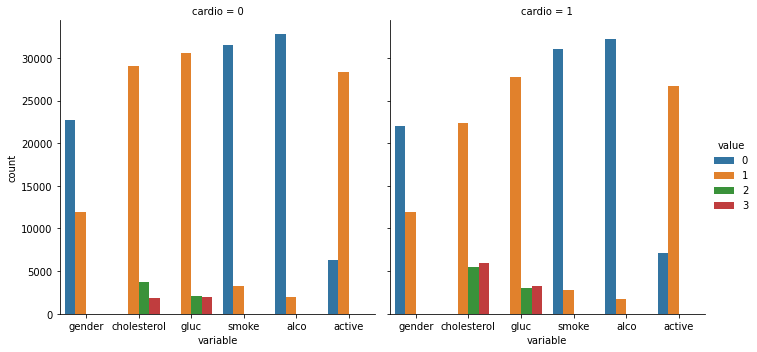

In [ ]:
# Presence and absence of CVDs over each categorical attribute
cat_df = pd.melt(cardio2, id_vars=['cardio'], value_vars=cat_attribs[:-1])        # dataframe of categorical attributes
sb.catplot(x='variable', hue='value', col='cardio', data=cat_df, kind='count')    # categorical plot

It can be seen that patients with CVD have higher cholesterol and glucose level.

Correlations matrix.

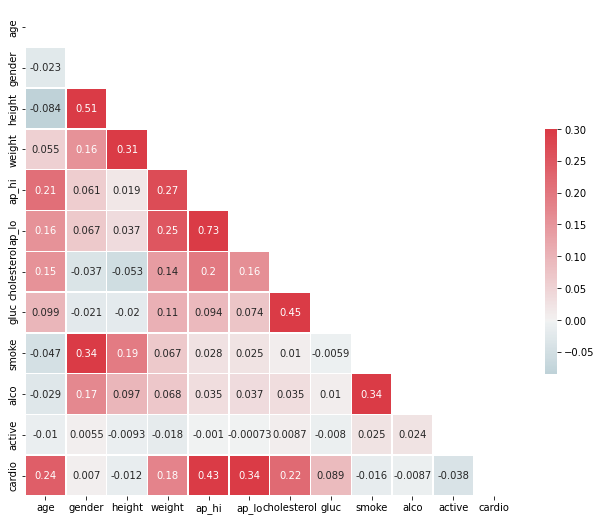

In [ ]:
# Calculate the correlations between attributes
corr = cardio2.astype('float').corr()
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, axes = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
           square=True, linewidths=.5, cbar_kws={"shrink": .5})

### VII.3. Prepare the Data

Scale features.

In [ ]:
# Import scaler
from sklearn.preprocessing import StandardScaler

# Define scaler object
scaler = StandardScaler()

# Scale numerical attributes
cardio2[num_attribs] = scaler.fit_transform(cardio2[num_attribs])

Split the dataset.

In [ ]:
# Import splitter
from sklearn.model_selection import train_test_split

# Separate the dataset
cardio2_label = pd.DataFrame(cardio2['cardio']) # label
cardio2 = cardio2.drop('cardio', axis=1)        # predictors

# Split the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(cardio2, cardio2_label, test_size=0.2, random_state=42)

### VII.4. Retrain the Model

##### VII.4.1. Train and Evaluate on Training Set

In [ ]:
# Import classification model and hyper-parameter optimizer
from sklearn.model_selection import GridSearchCV  # optimizer
from sklearn.tree import DecisionTreeClassifier   # model

# A dictionary contains hyper-parameters combinations that we want to examine
dectree_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(5, 10),
    'random_state': [42]
}

# Setup grid search
search_dectree = GridSearchCV(DecisionTreeClassifier(),
                              param_grid=dectree_param_grid,
                              scoring='roc_auc',
                              cv=10,
                              verbose=3)

# Fit the training set on the model with combinations of hyper-parameters
search_dectree.fit(X_train, y_train)

# The best hyper-parameters combination
search_dectree.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.786, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.795, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, random_state=42, score=0.784, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.785, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.804, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.795, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.796, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.795, total=   0.1s
[CV] criterion=gini, max_depth=5, random_state=42 ....................
[CV]  criterion=gini, max_depth=5, random_state=42, score=0.781, total=   0.1s
[CV] criterion=gini, 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.1s finished


{'criterion': 'gini', 'max_depth': 6, 'random_state': 42}

In [ ]:
# Create model object with the best found hyper-parameters combination
dectree = search_dectree.best_estimator_

# Fit the training set on the model
dectree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Accuracy:	 0.734234891011154
Precision:	 0.7645279213412328
Recall:		 0.6695984985095499
F1 score:	 0.7139213685945225
ROC AUC:	 0.7336257522336519


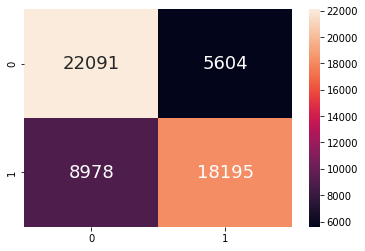

In [ ]:
# Import classification metrics
from sklearn.metrics import confusion_matrix                                                        # confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # metrics

# Create model evaluation object
evaluation = ModelEvaluation(y_train)

# Predict target class based on training set
y_train_pred = dectree.predict(X_train)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_train_pred)

Accuracy:	 0.7294233432966392
Precision:	 0.76027194797517
Recall:		 0.6625694623339344
F1 score:	 0.7080662288118929
ROC AUC:	 0.7287933067221215


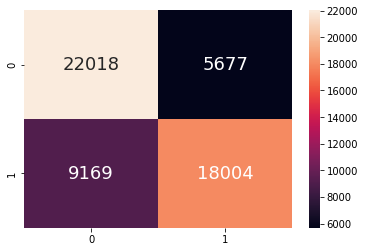

In [ ]:
# Import cross-validation predictor
from sklearn.model_selection import cross_val_predict # model validation

# Use cross-validation to predict target class based on training set
y_train_pred = cross_val_predict(dectree, X_train, y_train.values.flatten(), cv=10)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_train_pred)

In [ ]:
# The impact of each feature on the model
importances = list(zip(dectree.feature_importances_, X_train.columns))  # list of important features
importances.sort(reverse=True)                                          # sort the importances

# Print feature ranking
i = 1
for f in importances:                         # iterate over the list of important features
  print("{}. {} ({})".format(i, f[1], f[0]))  # print the ranking
  i += 1

1. ap_hi (0.7715068748440467)
2. age (0.1196285190111651)
3. cholesterol (0.07671518223395093)
4. weight (0.009091014688636238)
5. ap_lo (0.006712924399592935)
6. active (0.006250617005920727)
7. gluc (0.005416330677076446)
8. height (0.003329713752875033)
9. smoke (0.001348823386736047)
10. gender (0.0)
11. alco (0.0)


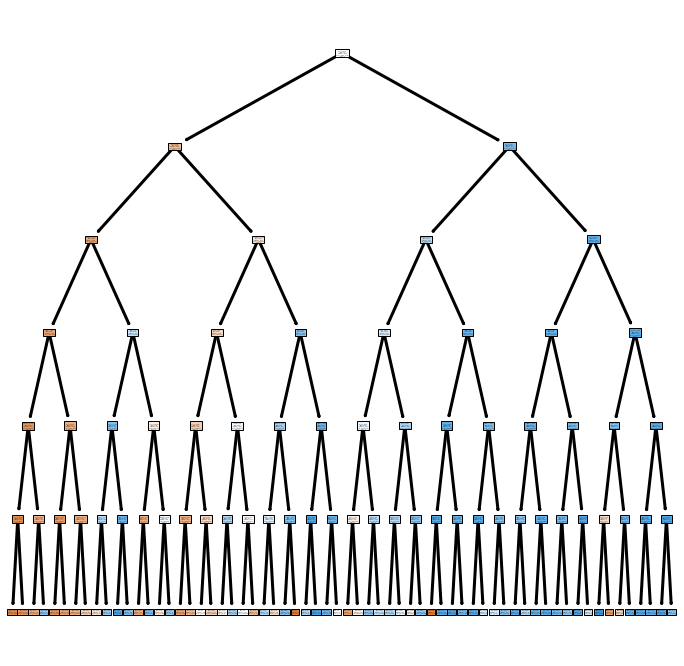

In [ ]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

fig, axes = plt.subplots(figsize=(12,12))
out = plot_tree(dectree,
                feature_names=X_train.columns,
                class_names=[str(x) for x in dectree.classes_],
                filled=True)

for o in out:
  arrow = o.arrow_patch
  if arrow is not None:
    arrow.set_edgecolor('black')
    arrow.set_linewidth(3)
        
plt.show()

##### VII.4.2. Evaluate on Test Set

Accuracy:	 0.727219711328182
Precision:	 0.7534223424032449
Recall:		 0.6613262127280819
F1 score:	 0.704376678780218
ROC AUC:	 0.7261052734845799


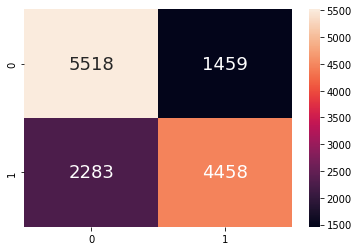

In [ ]:
# Create model evaluation object
evaluation = ModelEvaluation(y_test)

# Predict target class based on test set
y_test_pred = dectree.predict(X_test)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_test_pred)

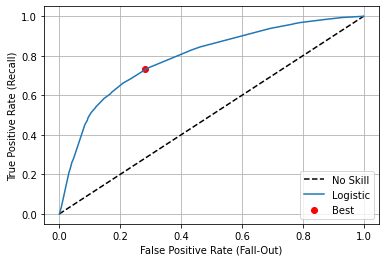

Best Threshold = 0.4744525547445255
G-Mean = 0.7243216638752316


In [ ]:
# Import essential libraries
from sklearn.metrics import roc_curve # roc curve metric
from numpy import sqrt                # calculate square root
from numpy import argmax              # find max value

# Predict target class probabilities based on test set
y_test_probas = dectree.predict_proba(X_test)

# Plot Receiver Operating Characteristic (ROC) curve
evaluation.plot_roc_curve(y_test_probas)

Accuracy:	 0.7237206589881907
Precision:	 0.7146806343663611
Recall:		 0.7286752707313455
F1 score:	 0.7216101072425445
ROC AUC:	 0.7238044549156227


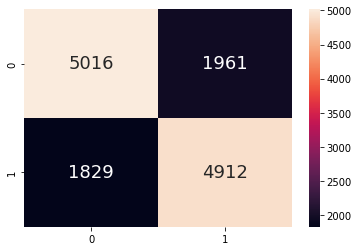

In [ ]:
# Set threshold to best threshold
threshold = evaluation.best_threshold()

# Use new threshold value to make new prediction based on test set
y_test_newpred = [1 if y_test_probas[i][1] > threshold else 0 for i in range(len(y_test_probas))]

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_test_newpred)

We're going to use another classification model to train the dataset on, which is the [Random Forest Classifier](https://towardsdatascience.com/understanding-random-forest-58381e0602d2).

# **VIII. More Classification Models**

### VIII.1. Random Forest Classifier

The Random Forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

##### VIII.1.1. Train and Evaluate on Training Set

In [ ]:
# Import classification model and hyper-parameter optimizer
from sklearn.model_selection import GridSearchCV    # optimizer
from sklearn.ensemble import RandomForestClassifier # model

# A dictionary contains hyper-parameters combinations that we want to examine
ranfor_param_grid = {
    'n_estimators': range(300, 450, 50),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(5, 10),
    'random_state': [42]
}

# Setup grid search
search_ranfor = GridSearchCV(RandomForestClassifier(),
                             param_grid=ranfor_param_grid,
                             scoring='roc_auc',
                             cv=10,
                             verbose=3)

# Fit the training set on the model with combinations of hyper-parameters
search_ranfor.fit(X_train, y_train.values.flatten())

# The best hyper-parameters combination
search_ranfor.best_params_

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] criterion=gini, max_depth=5, n_estimators=300, random_state=42 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=5, n_estimators=300, random_state=42, score=0.791, total=   5.6s
[CV] criterion=gini, max_depth=5, n_estimators=300, random_state=42 ..


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=300, random_state=42, score=0.799, total=   5.6s
[CV] criterion=gini, max_depth=5, n_estimators=300, random_state=42 ..


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=300, random_state=42, score=0.786, total=   5.6s
[CV] criterion=gini, max_depth=5, n_estimators=300, random_state=42 ..
[CV]  criterion=gini, max_depth=5, n_estimators=300, random_state=42, score=0.787, total=   5.5s
[CV] criterion=gini, max_depth=5, n_estimators=300, random_state=42 ..
[CV]  criterion=gini, max_depth=5, n_estimators=300, random_state=42, score=0.809, total=   5.5s
[CV] criterion=gini, max_depth=5, n_estimators=300, random_state=42 ..
[CV]  criterion=gini, max_depth=5, n_estimators=300, random_state=42, score=0.797, total=   5.5s
[CV] criterion=gini, max_depth=5, n_estimators=300, random_state=42 ..
[CV]  criterion=gini, max_depth=5, n_estimators=300, random_state=42, score=0.797, total=   5.6s
[CV] criterion=gini, max_depth=5, n_estimators=300, random_state=42 ..
[CV]  criterion=gini, max_depth=5, n_estimators=300, random_state=42, score=0.799, total=   5.5s
[CV] criterion=gini, max_depth=5, n_estimators=300, random_stat

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 40.4min finished


{'criterion': 'entropy',
 'max_depth': 9,
 'n_estimators': 350,
 'random_state': 42}

In [ ]:
# Create model object with the best found hyper-parameters combination
ranfor = search_ranfor.best_estimator_

# Fit the training set on the model
ranfor.fit(X_train, y_train.values.flatten())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Accuracy:	 0.7452431289640592
Precision:	 0.780565596427812
Recall:		 0.6754866963529974
F1 score:	 0.7242345328282827
ROC AUC:	 0.7445857384996618


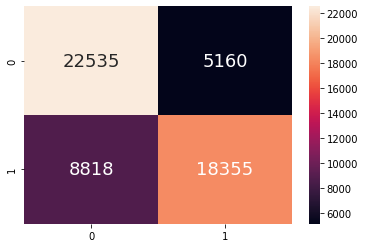

In [ ]:
# Import classification metrics
from sklearn.metrics import confusion_matrix                                                        # confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # metrics

# Create model evaluation object
evaluation = ModelEvaluation(y_train)

# Predict target class based on training set
y_train_pred = ranfor.predict(X_train)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_train_pred)

Accuracy:	 0.7344535977254502
Precision:	 0.7679323100471959
Recall:		 0.6646671328156626
F1 score:	 0.7125779215655329
ROC AUC:	 0.7337959242341537


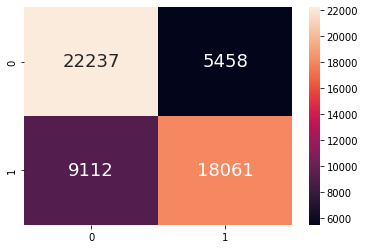

In [ ]:
# Import cross-validation predictor
from sklearn.model_selection import cross_val_predict # model validation

# Use cross-validation to predict target class based on training set
y_train_pred = cross_val_predict(ranfor, X_train, y_train.values.flatten(), cv=10)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_train_pred)

In [ ]:
# The impact of each feature on the model
importances = list(zip(ranfor.feature_importances_, X_train.columns))   # list of important features
importances.sort(reverse=True)                                          # sort the importances

# Print feature ranking
i = 1
for f in importances:                         # iterate over the list of important features
  print("{}. {} ({})".format(i, f[1], f[0]))  # print the ranking
  i += 1

1. ap_hi (0.47376071492121036)
2. ap_lo (0.19549493521024625)
3. age (0.1266145786546227)
4. cholesterol (0.09180357718470566)
5. weight (0.05384736965711177)
6. height (0.025017761460550715)
7. gluc (0.012811742614474953)
8. active (0.007529887873926873)
9. smoke (0.005180937622944499)
10. alco (0.004018483228233092)
11. gender (0.003920011571973103)


##### VIII.1.2. Evaluate on Test Set

Accuracy:	 0.7261991543956845
Precision:	 0.7558717641008058
Recall:		 0.6540572615338971
F1 score:	 0.7012883728328297
ROC AUC:	 0.7249790392519708


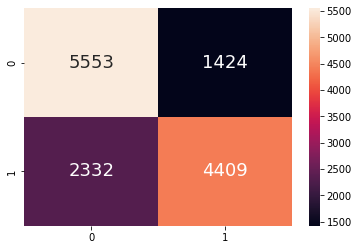

In [ ]:
# Create model evaluation object
evaluation = ModelEvaluation(y_test)

# Predict target class based on test set
y_test_pred = ranfor.predict(X_test)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_test_pred)

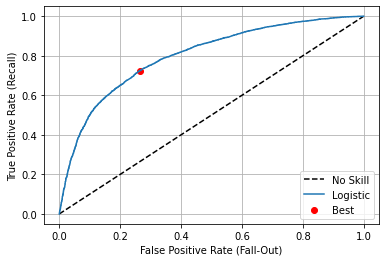

Best Threshold = 0.44857832559700617
G-Mean = 0.7302968248604884


In [ ]:
# Import essential libraries
from sklearn.metrics import roc_curve # roc curve metric
from numpy import sqrt                # calculate square root
from numpy import argmax              # find max value

# Predict target class probabilities based on test set
y_test_probas = ranfor.predict_proba(X_test)

# Plot roc curve
evaluation.plot_roc_curve(y_test_probas)

Accuracy:	 0.7303542790494241
Precision:	 0.7263392857142857
Recall:		 0.724076546506453
F1 score:	 0.725206151103187
ROC AUC:	 0.7302481055593754


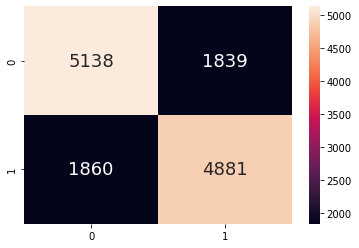

In [ ]:
# Set threshold to best threshold
threshold = evaluation.best_threshold()

# Use new threshold value to make new prediction based on test set
y_test_newpred = [1 if y_test_probas[i][1] > threshold else 0 for i in range(len(y_test_probas))]

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_test_newpred)

Let's try out another model which called [Gradient Boosting Classifier](https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab).

### VIII.2. Gradient Boosting Classifier

##### VIII.2.1. Train and Evaluate on Training Set

In [ ]:
# Import classification model and hyper-parameter optimizer
from sklearn.model_selection import GridSearchCV  # optimizer
from sklearn.ensemble import GradientBoostingClassifier   # model

# A dictionary contains hyper-parameters combinations that we want to examine
gb_param_grid = {
    'learning_rate': [0.03],
    'n_estimators': range(150, 300, 50),
    'max_depth': range(3, 8),
    'random_state': [42]
}

# Setup grid search
search_gb = GridSearchCV(GradientBoostingClassifier(),
                         param_grid=gb_param_grid,
                         scoring='roc_auc',
                         cv=10,
                         verbose=3)

# Fit the training set on the model with combinations of hyper-parameters
search_gb.fit(X_train, y_train.values.flatten())

# The best hyper-parameters combination
search_gb.best_params_

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42, score=0.795, total=   6.1s
[CV] learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV]  learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42, score=0.803, total=   6.0s
[CV] learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s


[CV]  learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42, score=0.791, total=   6.0s
[CV] learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42 
[CV]  learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42, score=0.792, total=   5.9s
[CV] learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42 
[CV]  learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42, score=0.813, total=   5.9s
[CV] learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42 
[CV]  learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42, score=0.801, total=   6.0s
[CV] learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42 
[CV]  learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42, score=0.802, total=   6.0s
[CV] learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42 
[CV]  learning_rate=0.03, max_depth=3, n_estimators=150, random_state=42, score=0.804, total=   6.0s
[CV] learning_rate=0.03, max_

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 31.5min finished


{'learning_rate': 0.03,
 'max_depth': 4,
 'n_estimators': 250,
 'random_state': 42}

In [ ]:
# Create model object with the best found hyper-parameters combination
gb = search_gb.best_estimator_

# Fit the training set on the model
gb.fit(X_train, y_train.values.flatten())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.03, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy:	 0.741014799154334
Precision:	 0.7635934767578999
Recall:		 0.6909800169285688
F1 score:	 0.7254742861558673
ROC AUC:	 0.7405432671752431


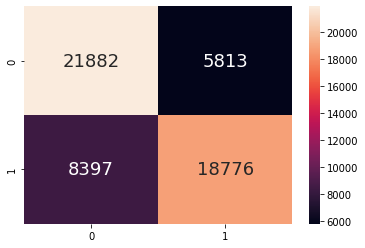

In [ ]:
# Import classification metrics
from sklearn.metrics import confusion_matrix                                                        # confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # metrics

# Create model evaluation object
evaluation = ModelEvaluation(y_train)

# Predict target class based on training set
y_train_pred = gb.predict(X_train)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_train_pred)

Accuracy:	 0.736039221404097
Precision:	 0.7563843542912558
Recall:		 0.6888823464468407
F1 score:	 0.7210569904277653
ROC AUC:	 0.7355948110641858


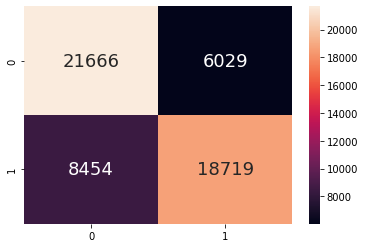

In [ ]:
# Import cross-validation predictor
from sklearn.model_selection import cross_val_predict # model validation

# Use cross-validation to predict target class based on training set
y_train_pred = cross_val_predict(gb, X_train, y_train.values.flatten(), cv=10)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_train_pred)

In [ ]:
# The impact of each feature on the model
importances = list(zip(gb.feature_importances_, X_train.columns))      # list of important features
importances.sort(reverse=True)                                          # sort the importances

# Print feature ranking
i = 1
for f in importances:                         # iterate over the list of important features
  print("{}. {} ({})".format(i, f[1], f[0]))  # print the ranking
  i += 1

1. ap_hi (0.7384829849689685)
2. age (0.12442024980279066)
3. cholesterol (0.07633019069123553)
4. weight (0.0224152503291574)
5. ap_lo (0.011381513976314848)
6. active (0.007391466953146436)
7. gluc (0.006299071137316351)
8. height (0.005653163778885532)
9. smoke (0.00424691034784652)
10. alco (0.002321355762590927)
11. gender (0.0010578422517473747)


Same as previous model, the situation happened, the way the dataset was preprocessed causes this model to be underfitted on the training set.

##### VIII.2.2. Evaluate on Test Set

Accuracy:	 0.7305000728969238
Precision:	 0.7489368662087014
Recall:		 0.6792760717994363
F1 score:	 0.7124076234928043
ROC AUC:	 0.729633736057379


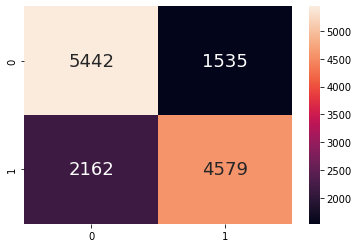

In [ ]:
# Create model evaluation object
evaluation = ModelEvaluation(y_test)

# Predict target class based on test set
y_test_pred = gb.predict(X_test)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_test_pred)

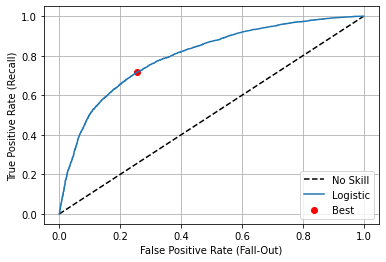

Best Threshold = 0.47061341539019813
G-Mean = 0.731225667068862


In [ ]:
# Import essential libraries
from sklearn.metrics import roc_curve # roc curve metric
from numpy import sqrt                # calculate square root
from numpy import argmax              # find max value

# Predict target class probabilities based on test set
y_test_probas = gb.predict_proba(X_test)

# Plot roc curve
evaluation.plot_roc_curve(y_test_probas)

Accuracy:	 0.7315206298294212
Precision:	 0.7311762927124282
Recall:		 0.7174009790832221
F1 score:	 0.7242231374017224
ROC AUC:	 0.7312818282258593


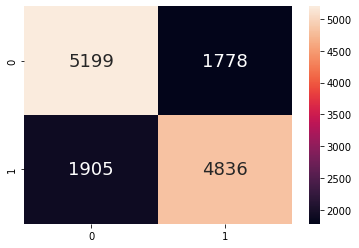

In [ ]:
# Set threshold to best threshold
threshold = evaluation.best_threshold()

# Use new threshold value to make new prediction based on test set
y_test_newpred = [1 if y_test_probas[i][1] > threshold else 0 for i in range(len(y_test_probas))]

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_test_newpred)

Lastly, let's give it a try with the [AdaBoost Classifier](https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe).

### VIII.3. AdaBoost Classifier

##### VIII.3.1. Train and Evaluate on Training Set

In [ ]:
# Import classification model and hyper-parameter optimizer
from sklearn.model_selection import GridSearchCV  # optimizer
from sklearn.ensemble import AdaBoostClassifier   # model

# A dictionary contains hyper-parameters combinations that we want to examine
ada_param_grid = {
    'n_estimators': range(50, 300, 50),
    'learning_rate': [0.03, 0.1, 0.3, 1],
    'random_state': [42]
}

# Setup grid search
search_ada = GridSearchCV(AdaBoostClassifier(),
                          param_grid=ada_param_grid,
                          scoring='roc_auc',
                          cv=10,
                          verbose=3)

# Fit the training set on the model with combinations of hyper-parameters
search_ada.fit(X_train, y_train.values.flatten())

# The best hyper-parameters combination
search_ada.best_params_

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] learning_rate=0.03, n_estimators=50, random_state=42 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.03, n_estimators=50, random_state=42, score=0.775, total=   1.3s
[CV] learning_rate=0.03, n_estimators=50, random_state=42 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  learning_rate=0.03, n_estimators=50, random_state=42, score=0.790, total=   1.3s
[CV] learning_rate=0.03, n_estimators=50, random_state=42 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV]  learning_rate=0.03, n_estimators=50, random_state=42, score=0.773, total=   1.3s
[CV] learning_rate=0.03, n_estimators=50, random_state=42 ............
[CV]  learning_rate=0.03, n_estimators=50, random_state=42, score=0.771, total=   1.3s
[CV] learning_rate=0.03, n_estimators=50, random_state=42 ............
[CV]  learning_rate=0.03, n_estimators=50, random_state=42, score=0.792, total=   1.3s
[CV] learning_rate=0.03, n_estimators=50, random_state=42 ............
[CV]  learning_rate=0.03, n_estimators=50, random_state=42, score=0.783, total=   1.3s
[CV] learning_rate=0.03, n_estimators=50, random_state=42 ............
[CV]  learning_rate=0.03, n_estimators=50, random_state=42, score=0.784, total=   1.3s
[CV] learning_rate=0.03, n_estimators=50, random_state=42 ............
[CV]  learning_rate=0.03, n_estimators=50, random_state=42, score=0.785, total=   1.3s
[CV] learning_rate=0.03, n_estimators=50, random_state=42 ............
[CV]  learning_rate=0.03, n_estimators=50, random_st

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 18.1min finished


{'learning_rate': 0.3, 'n_estimators': 250, 'random_state': 42}

In [ ]:
# Create model object with the best found hyper-parameters combination
ada = search_ada.best_estimator_

# Fit the training set on the model
ada.fit(X_train, y_train.values.flatten())

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.3,
                   n_estimators=250, random_state=42)

Accuracy:	 0.7319931471896187
Precision:	 0.7709021380149487
Recall:		 0.6528539358922459
F1 score:	 0.7069841586131312
ROC AUC:	 0.7312473326328895


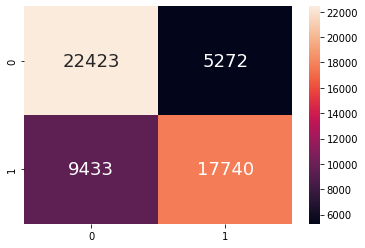

In [ ]:
# Import classification metrics
from sklearn.metrics import confusion_matrix                                                        # confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # metrics

# Create model evaluation object
evaluation = ModelEvaluation(y_train)

# Predict target class based on training set
y_train_pred = ada.predict(X_train)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_train_pred)

Accuracy:	 0.7302434934752496
Precision:	 0.7694955127646598
Recall:		 0.6500202406800869
F1 score:	 0.7047299858359767
ROC AUC:	 0.7294874628206357


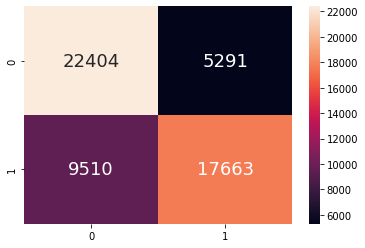

In [ ]:
# Import cross-validation predictor
from sklearn.model_selection import cross_val_predict # model validation

# Use cross-validation to predict target class based on training set
y_train_pred = cross_val_predict(ada, X_train, y_train.values.flatten(), cv=10)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_train_pred)

In [ ]:
# The impact of each feature on the model
importances = list(zip(ada.feature_importances_, X_train.columns))   # list of important features
importances.sort(reverse=True)                                       # sort the importances

# Print feature ranking
i = 1
for f in importances:                         # iterate over the list of important features
  print("{}. {} ({})".format(i, f[1], f[0]))  # print the ranking
  i += 1

1. age (0.276)
2. weight (0.204)
3. ap_hi (0.152)
4. ap_lo (0.12)
5. height (0.072)
6. cholesterol (0.064)
7. gluc (0.04)
8. active (0.028)
9. alco (0.02)
10. smoke (0.016)
11. gender (0.008)


##### VIII.3.2. Evaluate on Test Set

Accuracy:	 0.7224814112844438
Precision:	 0.7573684210526316
Recall:		 0.6404094348019582
F1 score:	 0.6939956595129009
ROC AUC:	 0.7210933514843961


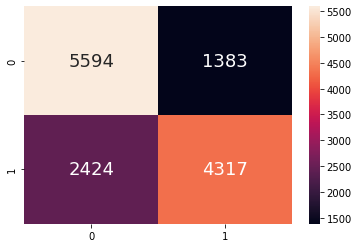

In [ ]:
# Create model evaluation object
evaluation = ModelEvaluation(y_test)

# Predict target class based on test set
y_test_pred = ada.predict(X_test)

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_test_pred)

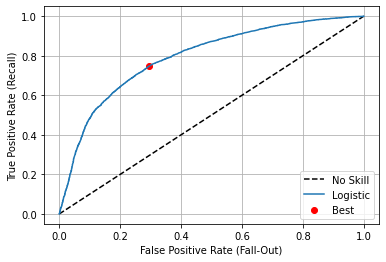

Best Threshold = 0.49865733559899855
G-Mean = 0.7262685712692871


In [ ]:
# Import essential libraries
from sklearn.metrics import roc_curve # roc curve metric
from numpy import sqrt                # calculate square root
from numpy import argmax              # find max value

# Predict target class probabilities based on test set
y_test_probas = ada.predict_proba(X_test)

# Plot roc curve
evaluation.plot_roc_curve(y_test_probas)

Accuracy:	 0.7261262574719347
Precision:	 0.7107940096072337
Recall:		 0.7463284379172229
F1 score:	 0.7281279397930386
ROC AUC:	 0.726467931155831


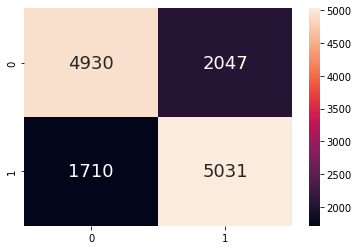

In [ ]:
# Set threshold to best threshold
threshold = evaluation.best_threshold()

# Use new threshold value to make new prediction based on test set
y_test_newpred = [1 if y_test_probas[i][1] > threshold else 0 for i in range(len(y_test_probas))]

# Plot confusion matrix
evaluation.plot_confusion_matrix(y_test_newpred)